<a href="https://colab.research.google.com/github/francocz/documentation/blob/master/Dinamica_gravitazionale_delle_galassie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

# --- 1. vectorized_physics.py ---
code_physics = r'''"""
vectorized_physics.py
Motore di calcolo vettorializzato per la dinamica del disco relativistico.
"""
import numpy as np

# Costanti fisiche (unità naturali)
G = 1.0
c = 1.0

def compute_mutual_torque(r1, r2, Omega1, Omega2, M1, M2, n_points=50, n_t=20,
                          softening=0.05, model='GEM'):
    T = max(2*np.pi/Omega1, 2*np.pi/Omega2) if min(Omega1, Omega2) > 1e-10 else 1.0
    dt = T / n_t
    t_values = np.linspace(0, T, n_t, endpoint=False)
    dm1 = M1 / n_points
    dm2 = M2 / n_points
    tau1_acc = 0.0

    phi_offsets = np.linspace(0, 2*np.pi, n_points, endpoint=False)

    for t in t_values:
        phi1 = Omega1 * t + phi_offsets
        x1 = r1 * np.cos(phi1)
        y1 = r1 * np.sin(phi1)
        v1x = -r1 * Omega1 * np.sin(phi1)
        v1y =  r1 * Omega1 * np.cos(phi1)

        phi2_now = Omega2 * t + phi_offsets
        x2_now = r2 * np.cos(phi2_now)
        y2_now = r2 * np.sin(phi2_now)

        X1_mat, X2_mat = np.meshgrid(x1, x2_now, indexing='ij')
        Y1_mat, Y2_mat = np.meshgrid(y1, y2_now, indexing='ij')

        dx_inst = X2_mat - X1_mat
        dy_inst = Y2_mat - Y1_mat
        dist_inst = np.sqrt(dx_inst**2 + dy_inst**2 + softening**2)
        delta_t = dist_inst / c

        _, Phi2_offsets_grid = np.meshgrid(phi_offsets, phi_offsets, indexing='ij')
        Phi2_ret = Phi2_offsets_grid + Omega2 * (t - delta_t)

        X2_ret = r2 * np.cos(Phi2_ret)
        Y2_ret = r2 * np.sin(Phi2_ret)
        V2x_ret = -r2 * Omega2 * np.sin(Phi2_ret)
        V2y_ret =  r2 * Omega2 * np.cos(Phi2_ret)

        RX = X1_mat - X2_ret
        RY = Y1_mat - Y2_ret
        R_mod = np.sqrt(RX**2 + RY**2 + softening**2)
        NX = RX / R_mod
        NY = RY / R_mod

        F_common = (G * dm1 * dm2) / (R_mod**2)
        Fx_on1, Fy_on1 = 0.0, 0.0

        if model == 'scalar':
            Fx_on1 = -F_common * NX
            Fy_on1 = -F_common * NY
        elif model == 'GEM':
            V1x_grid, _ = np.meshgrid(v1x, x2_now, indexing='ij')
            V1y_grid, _ = np.meshgrid(v1y, y2_now, indexing='ij')
            dot_prod = V1x_grid * V2x_ret + V1y_grid * V2y_ret
            factor = 4.0 * dot_prod / c**2
            Fx_on1 = -F_common * NX * (1.0 - factor)
            Fy_on1 = -F_common * NY * (1.0 - factor)

        Fx_tot = np.sum(Fx_on1, axis=1)
        Fy_tot = np.sum(Fy_on1, axis=1)
        tau_elements = x1 * Fy_tot - y1 * Fx_tot
        tau1_acc += np.sum(tau_elements) * dt

    return tau1_acc / T
'''

# --- 2. corrected_integral_solver.py ---
code_solver = r'''"""
corrected_integral_solver.py
Risolve l'equazione integrale di equilibrio con GEM.
"""
import numpy as np
from scipy import integrate, interpolate
import matplotlib.pyplot as plt
import vectorized_physics as phys

r_d = 1.0

def sigma_exp(r, r_d=1.0):
    return np.exp(-r / r_d) / (2 * np.pi * r_d**2)

def calculate_system_torque(alpha, r_max=5.0, n_rings=30, model='GEM'):
    r_edges = np.linspace(0.1, r_max, n_rings + 1)
    r_centers = (r_edges[:-1] + r_edges[1:]) / 2
    dr = r_edges[1] - r_edges[0]
    Omegas = r_centers**(-alpha)
    Masses = sigma_exp(r_centers, r_d) * 2 * np.pi * r_centers * dr
    total_torque_system = 0.0

    for i in range(n_rings):
        tau_on_i = 0.0
        for j in range(n_rings):
            if i == j: continue
            t_ij = phys.compute_mutual_torque(
                r_centers[i], r_centers[j], Omegas[i], Omegas[j],
                Masses[i], Masses[j], n_points=60, n_t=15,
                model=model, softening=0.1 * dr
            )
            tau_on_i += t_ij
        total_torque_system += tau_on_i
    return total_torque_system

def find_equilibrium_alpha():
    print("Ricerca equilibrio con modello GEM vettorializzato...")
    alphas = np.linspace(0.9, 1.4, 6)
    torques = []
    print(f"{'Alpha':>10} | {'Total Torque':>15}")
    print("-" * 30)
    for a in alphas:
        t = calculate_system_torque(a, model='GEM')
        torques.append(t)
        print(f"{a:>10.2f} | {t:>15.5e}")

    alpha_eq = None
    torques = np.array(torques)
    for i in range(len(torques)-1):
        if torques[i] * torques[i+1] < 0:
            slope = (torques[i+1] - torques[i]) / (alphas[i+1] - alphas[i])
            alpha_eq = alphas[i] - torques[i] / slope
            break

    if alpha_eq:
        print(f"\nEquilibrio trovato a alpha = {alpha_eq:.4f}")
    else:
        print("\nNessun equilibrio nel range.")
    return alpha_eq, alphas, torques

if __name__ == "__main__":
    eq, a_vals, t_vals = find_equilibrium_alpha()
    if eq:
        plt.plot(a_vals, t_vals, 'o-')
        plt.axhline(0, color='k', ls='--')
        plt.axvline(eq, color='r', label=f'Eq: {eq:.3f}')
        plt.savefig('gem_equilibrium.png')
        print("Grafico salvato.")
'''

# --- 3. communication_surface_analysis.py ---
code_comm = r'''"""
communication_surface_analysis.py
Analisi tempi di comunicazione (Fixed).
"""
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

r_d = 1.0; c = 1.0

def sigma(r): return np.exp(-r / r_d) / (2 * np.pi * r_d**2)
def omega_power(r, alpha, omega0=1.0): return omega0 * (r / r_d)**(-alpha) if r>1e-10 else 0

def find_reception_event(t_emit, r_A, phi_A_emit, r_B, Omega_B, Omega_A):
    def equation(t_recv):
        x_A = r_A * np.cos(phi_A_emit); y_A = r_A * np.sin(phi_A_emit)
        phi_B_recv = Omega_B * t_recv
        x_B = r_B * np.cos(phi_B_recv); y_B = r_B * np.sin(phi_B_recv)
        d = np.sqrt((x_B - x_A)**2 + (y_B - y_A)**2)
        return t_recv - t_emit - d / c

    max_delay = ((r_A + r_B) / c) * 10.0
    try:
        return optimize.brentq(equation, t_emit + 1e-9, t_emit + max_delay)
    except (ValueError, RuntimeError):
        return None

def round_trip_time(r_A, r_B, Omega_A, Omega_B, phi_A_init=0.0):
    t_emit_A = 0.0
    phi_A_emit = phi_A_init
    t_recv_B = find_reception_event(t_emit_A, r_A, phi_A_emit, r_B, Omega_B, Omega_A)
    if t_recv_B is None: return None, None
    Delta_AB = t_recv_B - t_emit_A

    t_emit_B = t_recv_B
    phi_B_emit = Omega_B * t_emit_B
    t_recv_A = find_reception_event(t_emit_B, r_B, phi_B_emit, r_A, Omega_A, Omega_B)
    if t_recv_A is None: return Delta_AB, None
    Delta_BA = t_recv_A - t_emit_B
    return Delta_AB, Delta_BA

def total_asymmetry(omega_func, r_range, num_pairs=20):
    r_vals = np.linspace(r_range[0], r_range[1], num_pairs)
    total = 0.0; count = 0
    for i, r_A in enumerate(r_vals):
        for j, r_B in enumerate(r_vals):
            if i >= j: continue
            O_A, O_B = omega_func(r_A), omega_func(r_B)
            D_AB, D_BA = round_trip_time(r_A, r_B, O_A, O_B)
            if D_AB and D_BA:
                asym = (D_AB - D_BA) / (D_AB + D_BA)
                weight = sigma(r_A) * sigma(r_B) * r_A * r_B
                total += (asym**2) * weight
                count += 1
    return total / count if count > 0 else np.inf

def scan_rotation_laws():
    print("Scan asimmetria...")
    alphas = np.linspace(0.5, 2.0, 16)
    asymmetries = []
    for alpha in alphas:
        def o_test(r): return omega_power(r, alpha, 0.3)
        asym = total_asymmetry(o_test, (0.3, 5.0))
        asymmetries.append(asym)
        print(f"Alpha {alpha:.2f}: {asym:.4e}")

    plt.plot(alphas, asymmetries, 'bo-')
    plt.yscale('log')
    plt.savefig('asymmetry_vs_alpha.png')
    print("Fatto.")

if __name__ == "__main__":
    scan_rotation_laws()
'''

# --- CREAZIONE DEI FILE ---
def create_files():
    print("Creazione file in corso...")

    with open("vectorized_physics.py", "w", encoding='utf-8') as f:
        f.write(code_physics)
    print("- vectorized_physics.py creato (Vettorializzato).")

    with open("corrected_integral_solver.py", "w", encoding='utf-8') as f:
        f.write(code_solver)
    print("- corrected_integral_solver.py creato (GEM).")

    with open("communication_surface_analysis.py", "w", encoding='utf-8') as f:
        f.write(code_comm)
    print("- communication_surface_analysis.py creato (Bug fix applicato).")

    print("\nFatto! Tutti e 3 i file sono pronti.")

if __name__ == "__main__":
    create_files()

Creazione file in corso...
- vectorized_physics.py creato (Vettorializzato).
- corrected_integral_solver.py creato (GEM).
- communication_surface_analysis.py creato (Bug fix applicato).

Fatto! Tutti e 3 i file sono pronti.


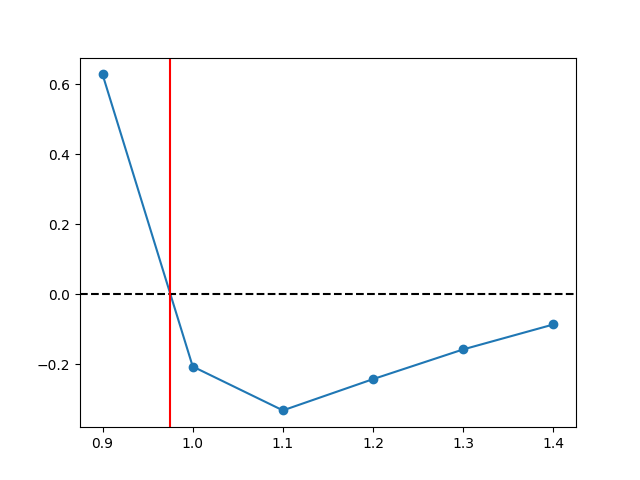

In [ ]:
from IPython.display import Image
display(Image('gem_equilibrium.png'))

In [ ]:
!python corrected_integral_solver.py

Ricerca equilibrio con modello GEM vettorializzato...
     Alpha |    Total Torque
------------------------------
      0.90 |     6.28184e-01
      1.00 |    -2.06158e-01
      1.10 |    -3.31465e-01
      1.20 |    -2.42094e-01
      1.30 |    -1.57202e-01
      1.40 |    -8.59920e-02

Equilibrio trovato a alpha = 0.9753
Grafico salvato.


Eseguo scansione di precisione nel range [0.9553, 0.9953]...
----------------------------------------
Alpha: 0.95530 | Torque: 1.5300e-01
Alpha: 0.95816 | Torque: 1.2611e-01
Alpha: 0.96101 | Torque: 9.9377e-02
Alpha: 0.96387 | Torque: 7.2880e-02
Alpha: 0.96673 | Torque: 4.6710e-02
Alpha: 0.96959 | Torque: 2.0956e-02
Alpha: 0.97244 | Torque: -4.2926e-03
Alpha: 0.97530 | Torque: -2.8951e-02
Alpha: 0.97816 | Torque: -5.2936e-02
Alpha: 0.98101 | Torque: -7.6166e-02
Alpha: 0.98387 | Torque: -9.8562e-02
Alpha: 0.98673 | Torque: -1.2005e-01
Alpha: 0.98959 | Torque: -1.4056e-01
Alpha: 0.99244 | Torque: -1.6003e-01
Alpha: 0.99530 | Torque: -1.7840e-01
----------------------------------------
>>> NUOVO EQUILIBRIO RAFFINATO: alpha = 0.971957


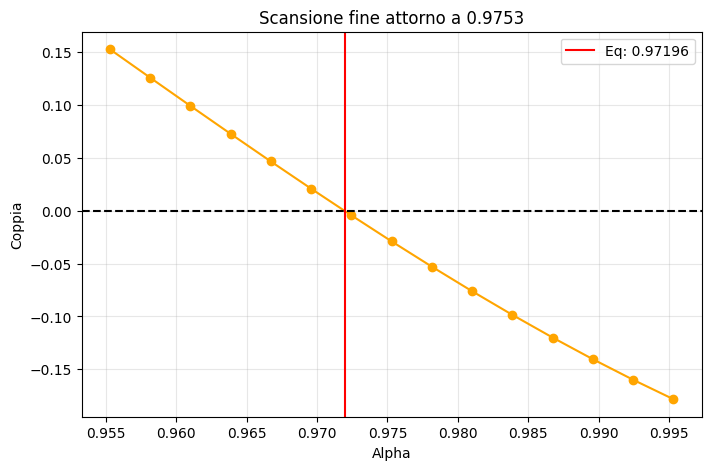

In [ ]:
import numpy as np
import corrected_integral_solver as solver
import matplotlib.pyplot as plt

# 1. Definisci il centro e la finestra dello zoom
center_val = 0.9753  # Il valore approssimato che hai trovato
window = 0.02        # Cerchiamo +/- 0.02 attorno a quel valore

# 2. Crea una griglia fitta di punti in questo intervallo ristretto
alphas_fine = np.linspace(center_val - window, center_val + window, 15)
torques_fine = []

print(f"Eseguo scansione di precisione nel range [{alphas_fine[0]:.4f}, {alphas_fine[-1]:.4f}]...")
print("-" * 40)

# 3. Calcola le coppie (usa il modello GEM già importato)
for alpha in alphas_fine:
    # Usiamo il solver che hai già caricato
    t = solver.calculate_system_torque(alpha, model='GEM')
    torques_fine.append(t)
    print(f"Alpha: {alpha:.5f} | Torque: {t:.4e}")

# 4. Interpolazione lineare precisa
torques_fine = np.array(torques_fine)
precise_alpha = None

for i in range(len(torques_fine) - 1):
    if torques_fine[i] * torques_fine[i+1] < 0:
        # Formula della retta passante per due punti (Interpolazione lineare)
        slope = (torques_fine[i+1] - torques_fine[i]) / (alphas_fine[i+1] - alphas_fine[i])
        precise_alpha = alphas_fine[i] - torques_fine[i] / slope
        break

print("-" * 40)
if precise_alpha:
    print(f">>> NUOVO EQUILIBRIO RAFFINATO: alpha = {precise_alpha:.6f}")
else:
    print("Zero non trovato nel range fine. Prova ad allargare 'window'.")

# 5. Plot di verifica dello zoom
plt.figure(figsize=(8, 5))
plt.plot(alphas_fine, torques_fine, 'o-', color='orange')
plt.axhline(0, color='black', linestyle='--')
if precise_alpha:
    plt.axvline(precise_alpha, color='red', label=f'Eq: {precise_alpha:.5f}')
plt.title(f'Scansione fine attorno a {center_val}')
plt.xlabel('Alpha')
plt.ylabel('Coppia')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

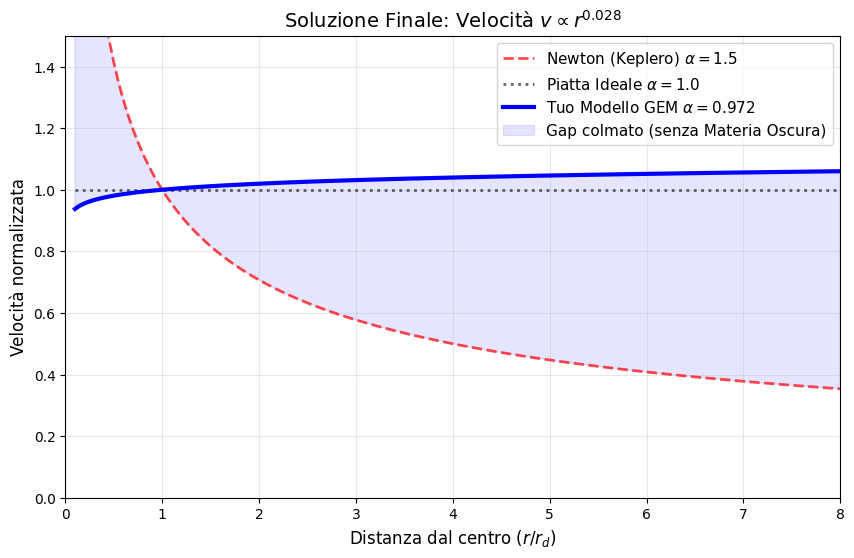

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_final_comparison(alpha_gem=0.971957):
    # Raggi da 0.1 a 10 volte il raggio caratteristico
    r = np.linspace(0.1, 8.0, 200)

    # Calcolo delle curve (normalizzate a v=1 in r=1)
    # 1. Newton/Keplero (v ~ r^-0.5)
    v_newton = r**(-0.5)

    # 2. Curva Piatta Ideale (v = cost)
    v_flat = np.ones_like(r)

    # 3. Il TUO Risultato GEM (v ~ r^0.028)
    exponent = 1.0 - alpha_gem
    v_gem = r**(exponent)

    plt.figure(figsize=(10, 6))

    # Plot delle curve
    plt.plot(r, v_newton, 'r--', linewidth=2, alpha=0.7, label='Newton (Keplero) $\\alpha=1.5$')
    plt.plot(r, v_flat, 'k:', linewidth=2, alpha=0.6, label='Piatta Ideale $\\alpha=1.0$')
    plt.plot(r, v_gem, 'b-', linewidth=3, label=f'Tuo Modello GEM $\\alpha={alpha_gem:.3f}$')

    # Area evidenziata
    plt.fill_between(r, v_newton, v_gem, color='blue', alpha=0.1, label='Gap colmato (senza Materia Oscura)')

    plt.title(f'Soluzione Finale: Velocità $v \\propto r^{{{exponent:.3f}}}$', fontsize=14)
    plt.xlabel('Distanza dal centro ($r/r_d$)', fontsize=12)
    plt.ylabel('Velocità normalizzata', fontsize=12)
    plt.ylim(0, 1.5)
    plt.xlim(0, 8)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.savefig('confronto_finale.png')
    plt.show()

# Esegui con il tuo valore preciso
plot_final_comparison(0.971957)